In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns

from scipy.stats import ttest_rel, ttest_ind
import numpy as np
import os
import yaml
import shutil

from matplotlib.ticker import MaxNLocator
from deep_experiments.utils import load_experiment_dirs, quick_load_experiments_tsv, get_significance_by_column 

barplot_kws = dict(linewidth=0.5, edgecolor="black", palette="Paired")

dpi = 200

%load_ext autoreload
%autoreload 2

%matplotlib inline

# Load data

In [2]:
exps = pd.read_table("../results.tsv", na_filter=False, quoting=3)

# Helper variables

In [3]:
LATIN = {
    "Hungarian",
    "Finnish",
    "Estonian",
    "Karelian",
    "Livvi",
    "North Sami",
    "Skolt Sami",
}
CYRILLIC = {"Erzya", "Komi Permyak", "Komi Zyrian", "Moksha"}

MODEL_NAME_MAPPING = {
    "SZTAKI-HLT/hubert-base-cc": "HuBERT",
    "TurkuNLP/bert-base-finnish-cased-v1": "FinBERT",
    "bert-base-multilingual-cased": "mBERT",
    "xlm-roberta-base": "XLM-RoBERTa",
    "tartuNLP/EstBERT": "EstBERT",
    "bert-base-cased": "EngBERT",
    "DeepPavlov/rubert-base-cased": "RuBERT",
}

SUPPORTED_LANGUAGES = {
    "EngBERT": LATIN,
    "mBERT": LATIN | CYRILLIC,
    "rand-mBERT": LATIN | CYRILLIC,
    "RuBERT": CYRILLIC,
    "HuBERT": LATIN,
    "EstBERT": LATIN,
    "EstBERT-nodiacritic": LATIN,
    "FinBERT": LATIN,
    "FinBERT-nodiacritic": LATIN,
    "XLM-RoBERTa": LATIN | CYRILLIC,
}

NO_DIACRITIC = {"tartuNLP/EstBERT", "TurkuNLP/bert-base-finnish-cased-v1"}

RANDOM_MODELS = {"bert-base-multilingual-cased"}

SMALL_LANGUAGES = [
    "Erzya",
    "Karelian",
    "Komi_Permyak",
    "Komi_Zyrian",
    "Livvi",
    "Moksha",
    "North_Sami",
    "Skolt_Sami",
    "Udmurt",
]

# Morphology

In [4]:
languages_tasks = set()

for lang_path in os.scandir(f"../data/morph"):
    language = lang_path.name
    for task in os.listdir(lang_path.path):
        languages_tasks.add((language, task))

In [5]:
exps['model'].value_counts()

HuBERT                 490
FinBERT                461
mBERT                  401
XLM-RoBERTa            387
EstBERT                354
EngBERT                318
rand-mBERT             225
EstBERT-nodiacritic    193
FinBERT-nodiacritic    177
RuBERT                  33
Name: model, dtype: int64

In [6]:
def is_supported(row):
    return row.language in SUPPORTED_LANGUAGES.get(row.model, {})

exps = exps[exps.apply(is_supported, axis=1)]

In [7]:
morph = exps[exps['train_file'].str.contains('/morph/')].copy()
pos = exps[exps['train_file'].str.contains('/pos/')].copy()
ner = exps[exps['train_file'].str.contains('/ner/')].copy()

In [8]:
morph = morph[morph['layer_pooling']=='weighted_sum'].copy()
pos = pos[pos['layer_pooling'].astype(str)=="12"].copy()
ner = ner[ner['layer_pooling'].astype(str)=="12"].copy()

In [9]:
assert len(set(morph.index) & set(pos.index)) == 0
assert len(set(morph.index) & set(ner.index)) == 0
assert len(set(pos.index) & set(ner.index)) == 0

In [10]:
morph['task'] = morph['train_file'].apply(lambda t: t.split("/")[-2])

# Morphology

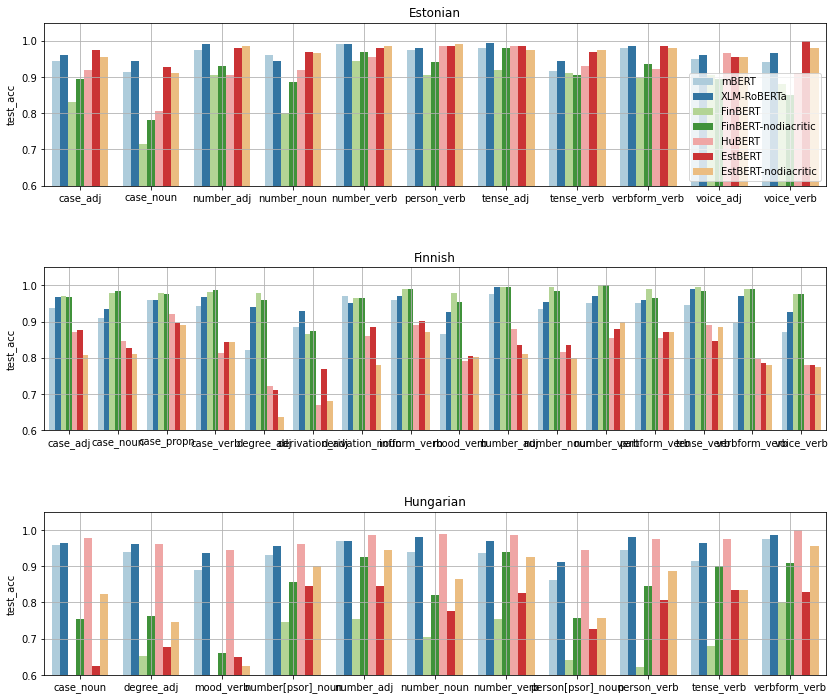

In [11]:
languages = sorted(set(morph.language))

fig, axes = plt.subplots(len(languages), figsize=(14, 12), facecolor='w')

for li, language in enumerate(languages):
    m = morph[(morph['language']==language) & (morph['subword_pooling']=='last') & (morph['train_base_model']==False)].copy()
    models = m.model.unique()
    model_order = ['mBERT', 'XLM-RoBERTa', 'FinBERT', 'FinBERT-nodiacritic', 'HuBERT', 'EstBERT', 'EstBERT-nodiacritic']
    m['model'] = pd.Categorical(m['model'], ordered=True, categories=model_order)
    m = m.sort_values('task')
    sns.barplot(x=m['task'], y=m['test_acc'], hue=m['model'], ax=axes[li], palette='Paired', ci=False)
    axes[li].set_title(language)
    axes[li].set_ylim(0.6, 1.05)
    axes[li].legend(loc='lower right')
    axes[li].grid(True)
    axes[li].set_xlabel("")
    if li > 0:
        axes[li].get_legend().remove()
    #plt.setp(axes[li].get_xticklabels(), Rotation=45, ha='right')
plt.subplots_adjust(hspace=.5)

## first-last gap is closed by finetuning

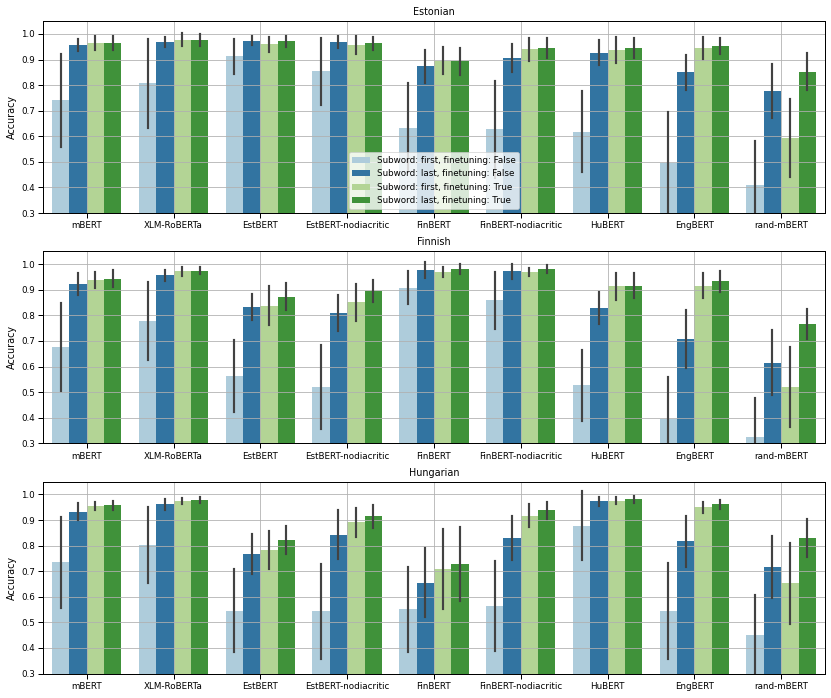

In [12]:
models_to_include = ['mBERT', 'XLM-RoBERTa', 'EstBERT', 'EstBERT-nodiacritic', 'FinBERT', 'FinBERT-nodiacritic',
                     'HuBERT', 'EngBERT', 'rand-mBERT']
m = morph[
    (morph.model.isin(models_to_include))
].groupby([
    'language', 'task', 'model', 'train_base_model', 'subword_pooling' 
]).test_acc.mean().reset_index()

languages = sorted(set(morph.language))

with sns.plotting_context('paper'):
    fig, axes = plt.subplots(len(languages), figsize=(14, 12), facecolor='w')

    for li, language in enumerate(languages):
        d = m[m['language']==language].copy()
        model_order = models_to_include
        d['model'] = pd.Categorical(d['model'], ordered=True, categories=model_order)
        d['type'] = "Subword: " + d['subword_pooling'] + ", finetuning: " + d['train_base_model'].astype(str)
        d['type'] = pd.Categorical(d['type'], ordered=True, categories=[
            'Subword: first, finetuning: False',
            'Subword: last, finetuning: False',
            'Subword: first, finetuning: True',
            'Subword: last, finetuning: True',
        ])
        m = m.sort_values('task')
        sns.barplot(x=d['model'], y=d['test_acc'], hue=d['type'], ax=axes[li], palette='Paired', ci='sd')
        axes[li].set_title(language)
        axes[li].set_ylim(0.3, 1.05)
        axes[li].set_ylabel("Accuracy")
        axes[li].legend(loc='lower center')
        axes[li].grid(True)
        axes[li].set_xlabel("")
        if li > 0:
            axes[li].get_legend().remove()
    plt.subplots_adjust(hspace=.2)
    fig.savefig("fig/bar_morph_first_last_by_language.pdf", bbox_inches='tight', pad_inches=0, format='pdf', dpi=1200)

In [13]:
paired = sns.color_palette('Paired')

In [14]:
morph.groupby(['language']).task.nunique()

language
Estonian     11
Finnish      16
Hungarian    11
Name: task, dtype: int64

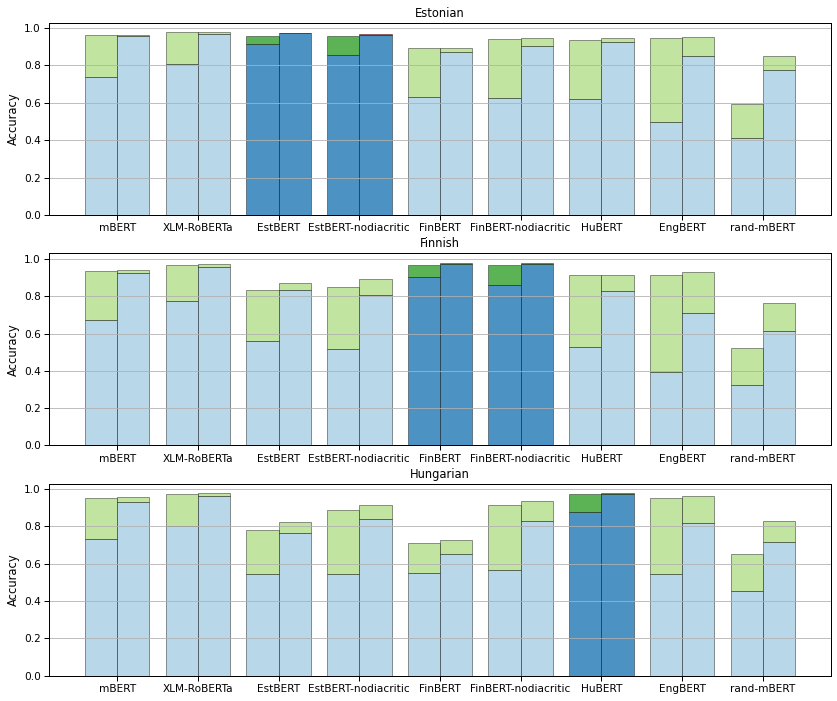

In [15]:
models_to_include = ['mBERT', 'XLM-RoBERTa', 'EstBERT', 'EstBERT-nodiacritic', 'FinBERT', 'FinBERT-nodiacritic',
                     'HuBERT', 'EngBERT', 'rand-mBERT']
m = morph[
    (morph.model.isin(models_to_include))
].groupby([
    'language', 'task', 'model', 'train_base_model', 'subword_pooling' 
]).test_acc.mean()
m = m.unstack(3)
m = m.groupby(['model', 'language', 'subword_pooling']).mean()
m['frozen'] = m[False]
m['finetuned'] = m[True]
m['finetuned-frozen']= m[True] - m[False]
m = m.reset_index()

languages = sorted(set(morph.language))

width = 0.4
kwargs = dict(linewidth=0.5, edgecolor='black', alpha=0.8)

with sns.plotting_context('paper', font_scale=1.2):
    fig, axes = plt.subplots(len(languages), figsize=(14, 12), facecolor='w')

    for li, language in enumerate(languages):
        model_order = models_to_include
        
        base_colors = [paired[0] if model[:2] != language[:2] else paired[1] for model in model_order]
        
        d = m[(m['language']==language) & (m['subword_pooling']=='first')].copy()
        d['model'] = pd.Categorical(d['model'], ordered=True, categories=model_order)
        d = d.sort_values('model')
        xpos = np.arange(0, len(model_order)) - width
        
        top_colors = []
        for model, row in d.set_index('model').loc[model_order].iterrows():
            if row['finetuned'] > row['frozen']:
                i = 2
            else:
                i = 4
            if model[:2] == language[:2]:
                i += 1
            top_colors.append(paired[i])
        axes[li].bar(x=xpos, height=d[['frozen', 'finetuned']].min(axis=1), width=width, align='edge',
                     color=base_colors, **kwargs)
        axes[li].bar(x=xpos, height=d['finetuned-frozen'].abs(), bottom=d[['frozen', 'finetuned']].min(axis=1), width=width, align='edge', color=top_colors, **kwargs)
        d1 = d
        
        d = m[(m['language']==language) & (m['subword_pooling']=='last')].copy()
        d['model'] = pd.Categorical(d['model'], ordered=True, categories=model_order)
        d = d.sort_values('model')
        
        axes[li].set_xticks(np.arange(len(model_order)))
        axes[li].set_xticklabels(model_order)
        
        top_colors = []
        for model, row in d.set_index('model').loc[model_order].iterrows():
            if row['finetuned'] > row['frozen']:
                i = 2
            else:
                i = 4
            if model[:2] == language[:2]:
                i += 1
            top_colors.append(paired[i])
        axes[li].bar(x=xpos+width, height=d[['frozen', 'finetuned']].min(axis=1), width=width, align='edge',
                     color=base_colors, **kwargs)
        axes[li].bar(x=xpos+width, height=d['finetuned-frozen'].abs(), bottom=d[['frozen', 'finetuned']].min(axis=1), width=width, align='edge', color=top_colors, **kwargs)
        
        axes[li].set_title(language)
        axes[li].set_ylabel("Accuracy")
        axes[li].grid(True, axis='y')
        axes[li].set_xlabel("")
    plt.subplots_adjust(hspace=.2)
    fig.savefig("fig/bar_morph_first_last_by_language.pdf", bbox_inches='tight', pad_inches=0, format='pdf', dpi=1200)
    fig.savefig("fig/bar_morph_first_last_by_language.png", bbox_inches='tight', pad_inches=0, format='png', dpi=600)

In [16]:
m = morph[
    (morph.model.isin(models_to_include))
].groupby([
    'language', 'task', 'model', 'train_base_model', 'subword_pooling' 
]).test_acc.mean().groupby(['language', 'model', 'train_base_model', 'subword_pooling']).mean()
m.reset_index().to_csv("tables/morphology.tsv", sep="\t", index=False, header=True)

In [17]:
m = morph.groupby(
    ['model', 'language', 'task', 'subword_pooling', 'train_base_model']
).test_acc.mean().unstack([-2, -1])

m['diff_finetuned'] = m[('last', True)] - m[('first', True)]
m['diff'] = m[('last', False)] - m[('first', False)]
m.mean()

subword_pooling  train_base_model
first            False               0.636238
                 True                0.882834
last             False               0.861491
                 True                0.919761
diff_finetuned                       0.036927
diff                                 0.225252
dtype: float64

Hungarian Degree ADJ first>last for some models:

In [18]:
m = morph[morph.train_base_model==False].groupby(['model', 'language', 'task', 'subword_pooling', 'train_base_model']).test_acc.mean().unstack(-2)
m[m['first'] > m['last']]

,,,subword_pooling,first,last
model,language,task,train_base_model,,
EngBERT,Hungarian,degree_adj,False,0.741294,0.686567
FinBERT,Hungarian,degree_adj,False,0.686567,0.651741
FinBERT-nodiacritic,Hungarian,degree_adj,False,0.781095,0.761194
rand-mBERT,Hungarian,degree_adj,False,0.587065,0.577114


# POS and NER

## Compute NER F1 scores

In [19]:
from seqeval.scheme import IOB1
from seqeval.metrics import f1_score

def tags_to_list_of_lists(tags, max_sentences=200):
    sentences = [[]]
    for tag in tags:
        if pd.isna(tag):
            sentences.append([])
            if len(sentences) >= max_sentences:
                return sentences
        else:
            sentences[-1].append(tag)
    if not sentences[-1]:
        return sentences[:-1]
    return sentences

ner_f1 = {}

for language, lang_df in ner.groupby(['language']):
    language = language.replace(" ", "_")
    test_ref = f"../data/ner/{language}/test"
    ref_df = pd.read_table(test_ref, skip_blank_lines=False, names=["token", "tag"])
    reference = tags_to_list_of_lists(ref_df['tag'].str.replace('1', 'S'))
    for _, row in lang_df.iterrows():
        pred_fn = f"{row.experiment_dir}/test.out"
        pred_df = pd.read_table(pred_fn, skip_blank_lines=False, names=["token", "tag"])
        test_tags = tags_to_list_of_lists(pred_df.tag.str.replace('1', 'S'))
        test_f1 = f1_score(reference, test_tags, scheme=IOB1)
        ner_f1[row['experiment_dir']] = test_f1

ner_f1 = pd.Series(ner_f1)
ner_f1.name = 'test_f1'

ner = ner.merge(ner_f1, left_on='experiment_dir', right_index=True)

## Rename nodiacritic models

EstBERT and FinBERT don't work well on other languages unless we remove the diacritics.

In [20]:
# Estonian
# remove Estonian EstBERT-nodiacritic
pos = pos[~((pos['language'] == 'Estonian') & (pos['model'] == 'EstBERT-nodiacritic'))]
# remove non-Estonian EstBERT
pos = pos[~((pos['language'] != 'Estonian') & (pos['model'] == 'EstBERT'))]
# change non-Estonian EstBERT-nodiacritic to EstBERT
pos.loc[pos['model']=='EstBERT-nodiacritic', 'model'] = 'EstBERT'

# Finnish
# remove Finnish FinBERT-nodiacritic
pos = pos[~((pos['language'] == 'Finnish') & (pos['model'] == 'FinBERT-nodiacritic'))]
# remove non-Finnish FinBERT
pos = pos[~((pos['language'] != 'Finnish') & (pos['model'] == 'FinBERT'))]
# change non-Finnish FinBERT-nodiacritic to FinBERT
pos.loc[pos['model']=='FinBERT-nodiacritic', 'model'] = 'FinBERT'

# Estonian
# remove Estonian EstBERT-nodiacritic
ner = ner[~((ner['language'] == 'Estonian') & (ner['model'] == 'EstBERT-nodiacritic'))]
# remove non-Estonian EstBERT
ner = ner[~((ner['language'] != 'Estonian') & (ner['model'] == 'EstBERT'))]
# change non-Estonian EstBERT-nodiacritic to EstBERT
ner.loc[ner['model']=='EstBERT-nodiacritic', 'model'] = 'EstBERT'

# Finnish
# remove Finnish FinBERT-nodiacritic
ner = ner[~((ner['language'] == 'Finnish') & (ner['model'] == 'FinBERT-nodiacritic'))]
# remove non-Finnish FinBERT
ner = ner[~((ner['language'] != 'Finnish') & (ner['model'] == 'FinBERT'))]
# change non-Finnish FinBERT-nodiacritic to FinBERT
ner.loc[ner['model']=='FinBERT-nodiacritic', 'model'] = 'FinBERT'

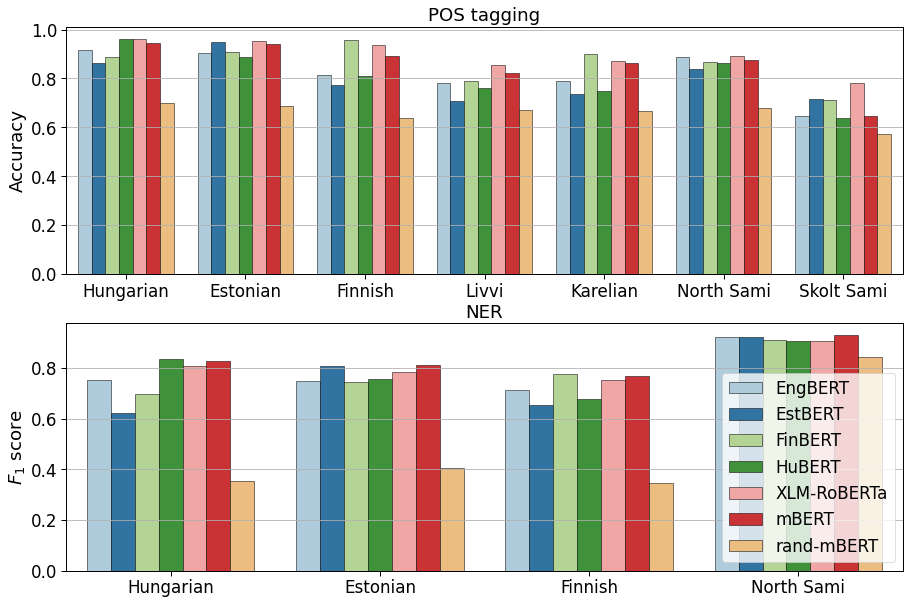

In [21]:
global_language_order = [
    "Hungarian",
    "Estonian",
    "Finnish",
    "Livvi",
    "Karelian",
    "North Sami",
    "Skolt Sami",
    "Erzya",
    "Moksha",
    "Komi Permyak",
    "Komi Zyrian",
]

# kwargs = dict(palette='Paired', alpha=0.8, edgecolor='black', linewidth=0.6)
with sns.plotting_context("paper", font_scale=1.9):
    fig, ax = plt.subplots(2, figsize=(15, 10), facecolor="w")
    pos_l = pos[
        (pos["train_base_model"] == True) & (pos["language"].isin(LATIN))
    ].copy()
    model_order = sorted(pos_l.model.unique())

    current_langs = set(pos_l.language)
    lang_order = [l for l in global_language_order if l in current_langs]
    pos_l["language"] = pd.Categorical(
        pos_l["language"], categories=lang_order, ordered=True
    )

    sns.barplot(
        x=pos_l["language"],
        y=pos_l["test_acc"],
        hue=pos_l["model"],
        ax=ax[0],
        hue_order=model_order,
        ci=None,
        **barplot_kws,
    )

    ner_l = ner[
        (ner["train_base_model"] == True) & (ner["language"].isin(LATIN))
    ].copy()

    current_langs = set(ner_l.language)
    lang_order = [l for l in global_language_order if l in current_langs]
    ner_l["language"] = pd.Categorical(
        ner_l["language"], categories=lang_order, ordered=True
    )

    sns.barplot(
        x=ner_l["language"],
        y=ner_l["test_f1"],
        hue=ner_l["model"],
        ax=ax[1],
        hue_order=model_order,
        ci=None,
        **barplot_kws,
    )

    ax[0].get_legend().remove()
    ax[1].legend(loc="lower right")

    ax[0].set_title("POS tagging")
    ax[1].set_title("NER")

    ax[0].set_ylabel("Accuracy")
    ax[1].set_ylabel("$F_1$ score")
    for a in ax:
        a.grid(True, axis="y")
        a.set_xlabel("")
    fig.savefig(
        "fig/bar_pos_ner_latin.pdf",
        bbox_inches="tight",
        pad_inches=0,
        format="pdf",
        dpi=1200,
    )
    fig.savefig(
        "fig/bar_pos_ner_latin.png",
        bbox_inches="tight",
        pad_inches=0,
        format="png",
        dpi=1200,
    )

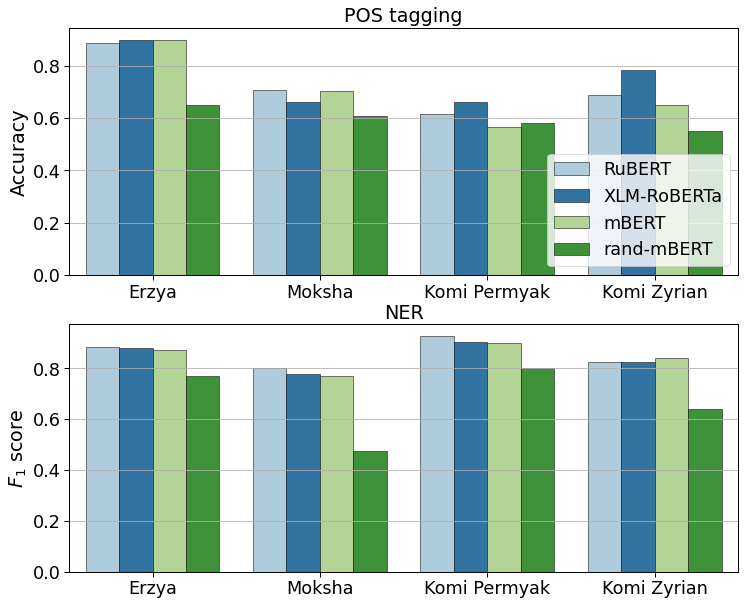

In [22]:
with sns.plotting_context("paper", font_scale=2):
    fig, ax = plt.subplots(2, figsize=(12, 10), facecolor="w")
    pos_l = pos[
        (pos["train_base_model"] == True) & (pos["language"].isin(CYRILLIC))
    ].copy()

    current_langs = set(pos_l.language)
    lang_order = [l for l in global_language_order if l in current_langs]
    pos_l["language"] = pd.Categorical(
        pos_l["language"], categories=lang_order, ordered=True
    )
    model_order = sorted(pos_l.model.unique())
    sns.barplot(
        x=pos_l["language"],
        y=pos_l["test_acc"],
        hue=pos_l["model"],
        ax=ax[0],
        hue_order=model_order,
        ci=None,
        **barplot_kws,
    )

    ner_l = ner[
        (ner["train_base_model"] == True) & (ner["language"].isin(CYRILLIC))
    ].copy()
    current_langs = set(ner_l.language)
    lang_order = [l for l in global_language_order if l in current_langs]
    ner_l["language"] = pd.Categorical(
        ner_l["language"], categories=lang_order, ordered=True
    )
    sns.barplot(
        x=ner_l["language"],
        y=ner_l["test_f1"],
        hue=ner_l["model"],
        ax=ax[1],
        hue_order=model_order,
        ci=None,
        **barplot_kws,
    )

    ax[0].legend(loc="lower right")
    ax[1].get_legend().remove()

    ax[0].set_title("POS tagging")
    ax[1].set_title("NER")

    ax[0].set_ylabel("Accuracy")
    ax[1].set_ylabel("$F_1$ score")
    for a in ax:
        a.grid(True, axis="y")
        a.set_xlabel("")
    fig.savefig(
        "fig/bar_pos_ner_cyrillic.pdf",
        bbox_inches="tight",
        pad_inches=0,
        format="pdf",
        dpi=1200,
    )
    fig.savefig(
        "fig/bar_pos_ner_cyrillic.png",
        bbox_inches="tight",
        pad_inches=0,
        format="png",
        dpi=1200,
    )

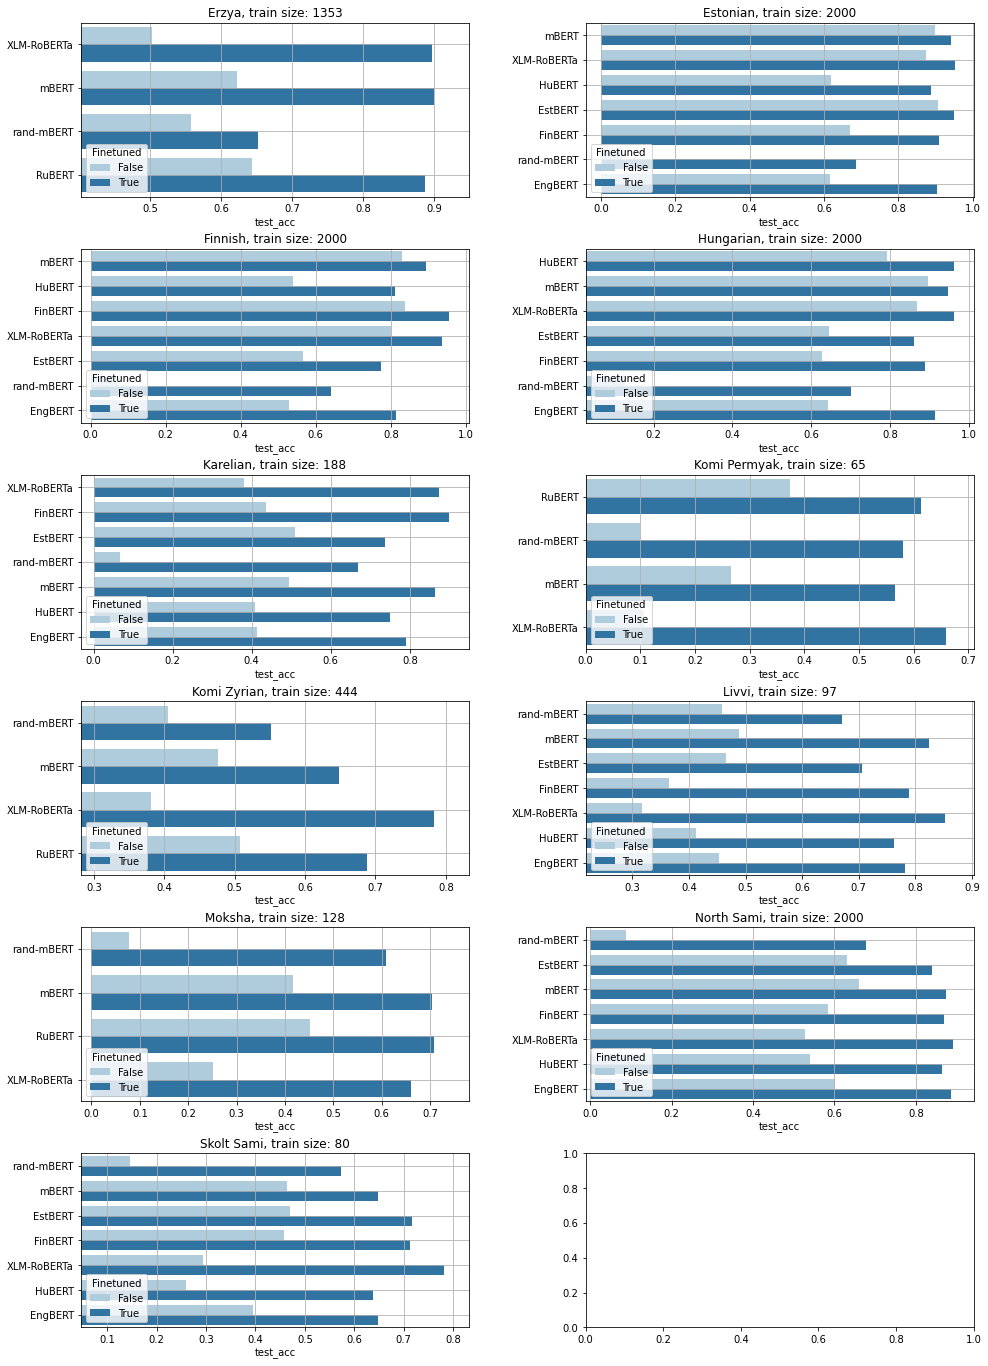

In [23]:
lang_no = pos['language'].nunique()

cols = 2
q, r = divmod(lang_no, cols)
rows = q if r == 0 else q + 1

fig, axes = plt.subplots(rows, cols, figsize=(16, rows * 4), facecolor='w')

for li, (language, df) in enumerate(pos.groupby('language')):
    ax = axes.flat[li]
    train_size = df['train_size'].unique()[0]
    ax.set_title(f"{language}, train size: {train_size}")
    sns.barplot(y=df['model'], x=df['test_acc'], hue=df['train_base_model'], ax=ax, ci=None, palette='Paired')
    ax.grid(True)
    ax.legend(title="Finetuned", loc='lower left')
    ax.set_ylabel("")
    acc_min = df['test_acc'].min()
    acc_max = df['test_acc'].max()
    ax.set_xlim(acc_min-0.1, acc_max+0.05)
    plt.subplots_adjust(hspace=0.3, wspace=0.3)

In [24]:
ner.loc[ner.groupby('language').test_f1.idxmax()][['language', 'model', 'train_base_model', 'test_f1']]

,language,model,train_base_model,test_f1
2718,Erzya,RuBERT,True,0.883295
2654,Estonian,mBERT,True,0.811258
2697,Finnish,FinBERT,True,0.778325
2673,Hungarian,HuBERT,True,0.844203
2723,Komi Permyak,RuBERT,True,0.926174
2615,Komi Zyrian,mBERT,True,0.843373
2667,Moksha,RuBERT,True,0.800000
2626,North Sami,mBERT,True,0.933333
